In [7]:
from matplotlib import pyplot as plt
from utils import config, sample_utils as su, parse_midas_data as pmd, plot_utils
from collections import defaultdict
import bz2, sys
import numpy as np
import pickle
import math
import scipy.stats

In [8]:
# Pickle directory
pickle_dir = "%s/pickles" % config.data_directory

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

In [9]:
# Load pickles
sample_species_polymorphism_dict = pickle.load(open("%s/sample_species_polymorphism_dict.pkl" % (pickle_dir), 'rb'))

In [10]:
# Load subject and sample metadata
sample_order_map = su.parse_sample_order_map()
subject_sample_map = su.parse_subject_sample_map()
sample_subject_map = su.parse_sample_subject_map()
sample_cohort_map = su.parse_sample_cohort_map()

all_samples = su.get_sample_names('all') # Note: c's removed
hmp_samples = su.get_sample_names('hmp')
olm_samples = su.get_sample_names('olm')
mother_samples_orig = su.get_sample_names('mother')
infant_samples = [sample for sample in su.get_sample_names('infant') if sample not in olm_samples]

mi_tp_sample_dict, infant_tps_ordered = su.get_mi_tp_sample_dict(exclude_cohorts = ['olm'], binned = True)
mother_tps_ordered = sorted(mi_tp_sample_dict['mother'].keys())
tps_ordered_dict = {'mother': mother_tps_ordered, 'infant': infant_tps_ordered}
mi_sample_day_dict = su.get_mi_sample_day_dict(exclude_cohorts=['olm'])

# Remove -92 and 92
mother_tps_ordered.remove(-92)
mother_tps_ordered.remove(92)
mother_samples = []
for sample in mother_samples_orig:
    if mi_sample_day_dict[sample] == -92 or mi_sample_day_dict[sample] == 92:
        continue
    mother_samples.append(sample)

# Species list
species_list = pmd.parse_species_list()
good_species_list = pmd.load_pickled_good_species_list()

# Utility functions
def round_down(num, divisor):
    return num - (num % divisor)

In [11]:
# Plot function
def plot_interval(y, xstart, xstop, color='b', tickh=0.1):
    """Plot interval at y from xstart to xstop with given color."""   
    plt.hlines(y, xstart, xstop, color, lw=1)
    plt.vlines(xstart, y+tickh, y-tickh, color, lw=1)
    plt.vlines(xstop, y+tickh, y-tickh, color, lw=1)

# Plot function on specific ax
def plot_interval_on_ax(ax, y, xstart, xstop, color='b', tickh=0.1):
    """Plot interval at y from xstart to xstop with given color."""   
    ax.hlines(y, xstart, xstop, color, lw=1)
    ax.vlines(xstart, y+tickh, y-tickh, color, lw=1)
    ax.vlines(xstop, y+tickh, y-tickh, color, lw=1)

In [12]:
# Qin metadata
qin_sample_subject_map = {}

qin_ids_fpath = "%s/qin_ids.txt" % (config.metadata_directory)
with open(qin_ids_fpath, 'r') as qin_file:
    header = qin_file.readline()
    for line in qin_file:
        items = line.strip().split('\t')
        qin_sample_subject_map[items[2]] = items[0]

In [13]:
# Alpha diversity, richness at different timepoints

# Relative abundance file
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (config.data_directory)
relab_file = open(relab_fpath, 'r')
decompressor = bz2.BZ2Decompressor()
raw = decompressor.decompress(relab_file.read())
data = [row.split('\t') for row in raw.split('\n')]
data.pop() # Get rid of extra element due to terminal newline
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
alpha_div_dict = {}
richness_dict = {}
for i in range(1, len(header)):
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    alpha_div_dict[header[i]] = (acc*-1)
    richness_dict[header[i]] = richness

In [14]:
# Store relative abundances

# Relative abundance file
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (config.data_directory)
relab_file = open(relab_fpath, 'r')
decompressor = bz2.BZ2Decompressor()
raw = decompressor.decompress(relab_file.read())
data = [row.split('\t') for row in raw.split('\n')]
data.pop() # Get rid of extra element due to terminal newline
header = su.parse_merged_sample_names(data[0])

relab_dict = defaultdict(dict) # sample -> species -> relab

for i in range(1, len(header)):
    sample = header[i]
    for row in data[1:]:
        species = row[0]
        rel_ab = float(row[i])
        if rel_ab > 0:
            relab_dict[sample][species] = rel_ab

In [15]:
# Poyet, Korpela, Qin adult data too

korpela_data_dir = '/u/home/d/daisyche/dbd/data_korpela/'
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (korpela_data_dir)
relab_file = open(relab_fpath, 'r')
decompressor = bz2.BZ2Decompressor()
raw = decompressor.decompress(relab_file.read())
data = [row.split('\t') for row in raw.split('\n')]
data.pop() # Get rid of extra element due to terminal newline
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
korpela_alpha_div_dict = {}
korpela_richness_dict = {}
for i in range(1, len(header)):
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    korpela_alpha_div_dict[header[i]] = (acc*-1)
    korpela_richness_dict[header[i]] = richness

poyet_data_dir = '/u/home/d/daisyche/dbd/data_poyet/'
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (poyet_data_dir)
relab_file = open(relab_fpath, 'r')
decompressor = bz2.BZ2Decompressor()
raw = decompressor.decompress(relab_file.read())
data = [row.split('\t') for row in raw.split('\n')]
data.pop() # Get rid of extra element due to terminal newline
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
poyet_alpha_div_dict = {}
poyet_richness_dict = {}
for i in range(1, len(header)):
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    poyet_alpha_div_dict[header[i]] = (acc*-1)
    poyet_richness_dict[header[i]] = richness

qin_data_dir = '/u/home/d/daisyche/mother_infant/Qin_species/'
relab_fpath = "%s/relative_abundance.txt.bz2" % (qin_data_dir)
relab_file = open(relab_fpath, 'r')
decompressor = bz2.BZ2Decompressor()
raw = decompressor.decompress(relab_file.read())
data = [row.split('\t') for row in raw.split('\n')]
data.pop() # Get rid of extra element due to terminal newline
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
qin_alpha_div_dict = {}
qin_richness_dict = {}
for i in range(1, len(header)):
    sample = header[i]
    if sample not in qin_sample_subject_map:
        continue
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    qin_alpha_div_dict[sample] = (acc*-1)
    qin_richness_dict[sample] = richness

In [16]:
# Make CSV to make linear model
# alpha diversity ~ pregnancy (mother vs. adult) + cohort

output_file = open('%s/alpha_div_preg_status.csv' % config.analysis_directory, 'wb')
output_file.write(','.join(['sample', 'subject', 'alpha_div', 'preg_status', 'cohort']) + '\n')

for sample in alpha_div_dict:
    subject = sample_subject_map[sample]
    alpha_div = alpha_div_dict[sample]
    
    if sample in hmp_samples:
        preg_status = 0
    elif sample in mother_samples:
        preg_status = 1
    else:
        continue
    
    cohort = sample_cohort_map[sample]
    output_file.write(','.join([str(v) for v in [sample, subject, alpha_div, preg_status, cohort]]) + '\n')

for sample in qin_alpha_div_dict:
    subject = qin_sample_subject_map[sample]
    alpha_div = qin_alpha_div_dict[sample]
    preg_status = 0
    cohort = 'qin'
    output_file.write(','.join([str(v) for v in [sample, subject, alpha_div, preg_status, cohort]]) + '\n')

output_file.close()

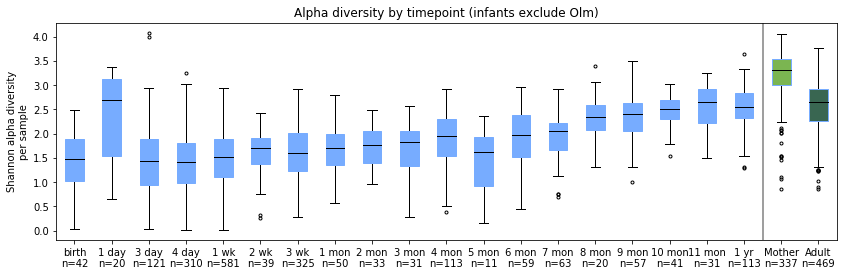

In [17]:
alpha_divs = [] # list of sample values for each tp
labels = []
sample_sizes = []

for tp in infant_tps_ordered:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    if num_samples < 10:
        continue # Skip timepoints with not enough data
    labels.append(tp + "\n" + ("n=%i" % num_samples))
    alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['infant'][tp]]
    alpha_divs.append(alpha_divs_tp)
    sample_sizes.append(num_samples)


alpha_divs_mother_combined = []
for i in range(len(mother_tps_ordered)):
    tp = mother_tps_ordered[i]
    num_samples = len(mi_tp_sample_dict['mother'][tp])
    alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['mother'][tp]]
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    alpha_divs_mother_combined += alpha_divs_tp

alpha_divs.append(alpha_divs_mother_combined)
labels.append('Mother'+ "\n" + ("n=%i" % len(alpha_divs_mother_combined)))
sample_sizes.append(len(alpha_divs_mother_combined))

alpha_divs_hmp = [alpha_div_dict[sample] for sample in hmp_samples]
alpha_divs.append(alpha_divs_hmp)
labels.append('Adult' + "\n" + ("n=%i" % len(alpha_divs_hmp)))
sample_sizes.append(len(alpha_divs_hmp))

fig, ax = plt.subplots(figsize=(14, 4))

boxprops = dict(color='#77acff')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(alpha_divs, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

boxplots['boxes'][-1].set_facecolor('#396651')
boxplots['boxes'][-2].set_facecolor('#7bb551')

ax.set_ylabel("Shannon alpha diversity\nper sample")
ax.set_title("Alpha diversity by timepoint (infants exclude Olm)")
ax.axvline(19.5, color='gray', linestyle='-')
ax.set_xticklabels(labels)

plt.show()

In [18]:
import scipy.stats

# Get statistics for paper
alpha_divs_birth = alpha_divs[0]
print("Median alpha diversity, birth: %.02f" % np.median(alpha_divs_birth))
alpha_divs_1day = alpha_divs[1]
print("Median alpha diversity, 1 day: %.02f" % np.median(alpha_divs_1day))
alpha_divs_3day = alpha_divs[2]
print("Median alpha diversity, 3 days: %.02f" % np.median(alpha_divs_3day))
alpha_divs_mother = alpha_divs[-2]
print("Median alpha diversity, mother: %.02f" % np.median(alpha_divs_mother))
alpha_divs_adult = alpha_divs[-1]
print("Median alpha diversity, adult: %.02f" % np.median(alpha_divs_adult))

t, p = scipy.stats.ttest_ind(alpha_divs_birth, alpha_divs_1day)
print("T-test p-value for alpha div increase, birth->1 day: %f" % p)
t, p = scipy.stats.ttest_ind(alpha_divs_1day, alpha_divs_3day)
print("T-test p-value for alpha div decrease, 1 day->3 days: %f" % p)
t, p = scipy.stats.ttest_ind(alpha_divs_mother, alpha_divs_adult)
print("T-test p-value for alpha div mother vs. adult: %s" % str(p))

print("Sample sizes range from %i to %i with median of %.02f." % (min(sample_sizes), max(sample_sizes), np.median(sample_sizes)))

Median alpha diversity, birth: 1.48
Median alpha diversity, 1 day: 2.70
Median alpha diversity, 3 days: 1.43
Median alpha diversity, mother: 3.32
Median alpha diversity, adult: 2.65
T-test p-value for alpha div increase, birth->1 day: 0.000015
T-test p-value for alpha div decrease, 1 day->3 days: 0.000004
T-test p-value for alpha div mother vs. adult: 1.0011503809718605e-61
Sample sizes range from 11 to 581 with median of 57.00.


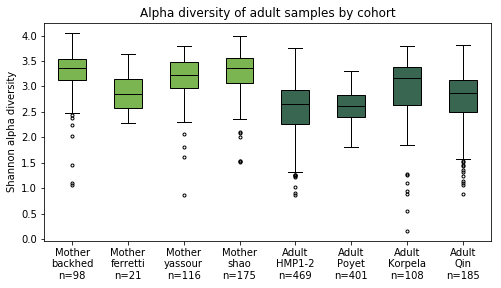

In [12]:
# Mom from each cohort, HMP1-2, Poyet, Korpela

alpha_divs_mother_by_cohort = defaultdict(list)

sample_cohort_map = su.parse_sample_cohort_map()
mother_samples = su.get_sample_names('mother')
hmp_samples = su.get_sample_names('hmp')
mother_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

for sample in mother_samples:
    cohort = sample_cohort_map[sample]
    alpha_div = alpha_div_dict[sample]
    alpha_divs_mother_by_cohort[cohort].append(alpha_div)

alpha_divs = []
labels = []
for cohort in mother_cohorts:
    alpha_divs.append(alpha_divs_mother_by_cohort[cohort])
    labels.append('Mother\n%s\nn=%i' % (cohort, len(alpha_divs_mother_by_cohort[cohort])))

hmp_alpha_divs = [alpha_div_dict[sample] for sample in hmp_samples]
alpha_divs.append(hmp_alpha_divs)
labels.append('Adult\nHMP1-2\nn=%i' % (len(hmp_alpha_divs)))
alpha_divs.append(poyet_alpha_div_dict.values())
labels.append('Adult\nPoyet\nn=%i' % (len(poyet_alpha_div_dict)))
alpha_divs.append(korpela_alpha_div_dict.values())
labels.append('Adult\nKorpela\nn=%i' % (len(korpela_alpha_div_dict)))
alpha_divs.append(qin_alpha_div_dict.values())
labels.append('Adult\nQin\nn=%i' % (len(qin_alpha_div_dict)))

fig, ax = plt.subplots(figsize=(8, 4))

medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(alpha_divs, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes'][:4]:
    patch.set_facecolor('#7bb551')
for patch in boxplots['boxes'][-4:]:
    patch.set_facecolor('#396651')

ax.set_ylabel("Shannon alpha diversity")
ax.set_title("Alpha diversity of adult samples by cohort")
ax.set_xticklabels(labels)

plt.show()
fig.savefig('%s/alpha_div_adults_by_cohort.pdf' % (config.analysis_directory), bbox_inches='tight')

3.7037455007504035e-12
0.3389608252243167
2.671998141958257e-05
1.8450772850577738e-19


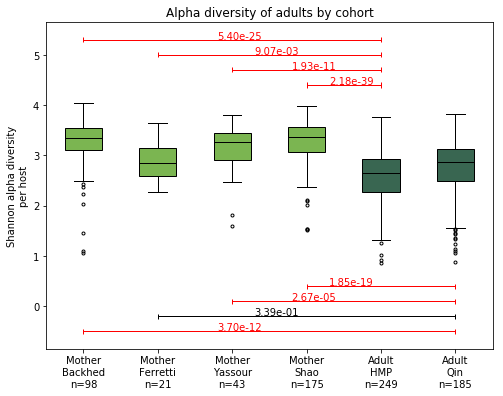

In [13]:
# Mom from each cohort, HMP1-2, Qin, pick one sample per host

alpha_divs_mother_by_subject = {}

for sample in mother_samples:
    subject = sample_subject_map[sample]
    alpha_div = alpha_div_dict[sample]
    alpha_divs_mother_by_subject[subject] = (alpha_div, sample)

alpha_divs_mother_by_cohort = defaultdict(list)

sample_cohort_map = su.parse_sample_cohort_map()
mother_samples = su.get_sample_names('mother')
hmp_samples = su.get_sample_names('hmp')
mother_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

for subject in alpha_divs_mother_by_subject:
    alpha_div, rep_sample = alpha_divs_mother_by_subject[subject]
    cohort = sample_cohort_map[rep_sample]
    alpha_divs_mother_by_cohort[cohort].append(alpha_div)

alpha_divs = []
labels = []
for cohort in mother_cohorts:
    alpha_divs.append(alpha_divs_mother_by_cohort[cohort])
    labels.append('Mother\n%s\nn=%i' % (cohort.capitalize(), len(alpha_divs_mother_by_cohort[cohort])))

alpha_divs_hmp_by_subject = {}
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    alpha_div = alpha_div_dict[sample]
    alpha_divs_hmp_by_subject[subject] = alpha_div

alpha_divs.append(alpha_divs_hmp_by_subject.values())
labels.append('Adult\nHMP\nn=%i' % (len(alpha_divs_hmp_by_subject)))

alpha_divs_qin_by_subject = {}
for sample in qin_alpha_div_dict:
    subject = qin_sample_subject_map[sample]
    alpha_div = qin_alpha_div_dict[sample]
    alpha_divs_qin_by_subject[subject] = alpha_div              
              
alpha_divs.append(alpha_divs_qin_by_subject.values())
labels.append('Adult\nQin\nn=%i' % (len(alpha_divs_qin_by_subject)))

fig, ax = plt.subplots(figsize=(8, 6))

medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(alpha_divs, patch_artist=True, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes'][:4]:
    patch.set_facecolor('#7bb551')
for patch in boxplots['boxes'][-2:]:
    patch.set_facecolor('#396651')

# Perform pairwise t-test
j = 0
for i in [0, 1, 2, 3]:
    a1 = alpha_divs[i]
    a2 = alpha_divs[4] # Compare to HMP first
    t, p = scipy.stats.ttest_ind(a1, a2)
    color = 'red' if p < 0.05 else 'black'
    plot_interval(5.3 - j, i+1, 5, color=color, tickh=0.05)
    plt.text(0.8+i+((4-i)/2.0), 5.3 - j+0.02, '{:.2e}'.format(p), color=color)
    j += 0.3

j = 0
for i in [0, 1, 2, 3]:
    a1 = alpha_divs[i]
    a2 = alpha_divs[5] # Compare to Qin
    t, p = scipy.stats.ttest_ind(a1, a2)
    print(p)
    color = 'red' if p < 0.05 else 'black'
    plot_interval(-0.5+j, i+1, 6, color=color, tickh=0.05)
    plt.text(0.8+i+((4-i)/2.0), -0.5+j+0.02, '{:.2e}'.format(p), color=color)
    j += 0.3

ax.set_ylabel("Shannon alpha diversity\nper host")
ax.set_title("Alpha diversity of adults by cohort")
ax.set_xticklabels(labels)

plt.show()
fig.savefig('%s/alpha_div_adults_by_cohort.pdf' % (config.analysis_directory), bbox_inches='tight')

In [14]:
# Save labels for combined plot
alpha_div_adults_by_cohort_labels = labels

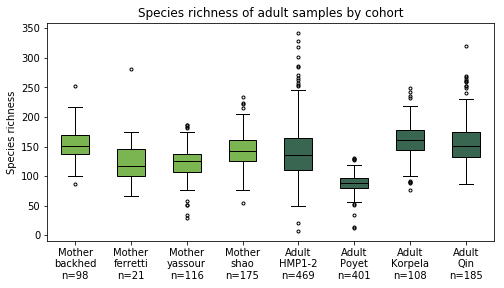

In [15]:
# Mom from each cohort, HMP1-2, Poyet, Korpela

richnesses_mother_by_cohort = defaultdict(list)

sample_cohort_map = su.parse_sample_cohort_map()
mother_samples = su.get_sample_names('mother')
hmp_samples = su.get_sample_names('hmp')
mother_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

for sample in mother_samples:
    cohort = sample_cohort_map[sample]
    richness = richness_dict[sample]
    richnesses_mother_by_cohort[cohort].append(richness)

richnesses = []
labels = []
for cohort in mother_cohorts:
    richnesses.append(richnesses_mother_by_cohort[cohort])
    labels.append('Mother\n%s\nn=%i' % (cohort, len(richnesses_mother_by_cohort[cohort])))

hmp_richnesses = [richness_dict[sample] for sample in hmp_samples]
richnesses.append(hmp_richnesses)
labels.append('Adult\nHMP1-2\nn=%i' % (len(hmp_richnesses)))
richnesses.append(poyet_richness_dict.values())
labels.append('Adult\nPoyet\nn=%i' % (len(poyet_richness_dict)))
richnesses.append(korpela_richness_dict.values())
labels.append('Adult\nKorpela\nn=%i' % (len(korpela_richness_dict)))
richnesses.append(qin_richness_dict.values())
labels.append('Adult\nQin\nn=%i' % (len(qin_richness_dict)))

fig, ax = plt.subplots(figsize=(8, 4))

medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(richnesses, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes'][:4]:
    patch.set_facecolor('#7bb551')
for patch in boxplots['boxes'][-4:]:
    patch.set_facecolor('#396651')

ax.set_ylabel("Species richness")
ax.set_title("Species richness of adult samples by cohort")
ax.set_xticklabels(labels)

plt.show()
fig.savefig('%s/richness_adults_by_cohort.pdf' % (config.analysis_directory), bbox_inches='tight')

0.30095257610397425
0.0010380843863988405
7.993881414495057e-10
0.0007974364818429491


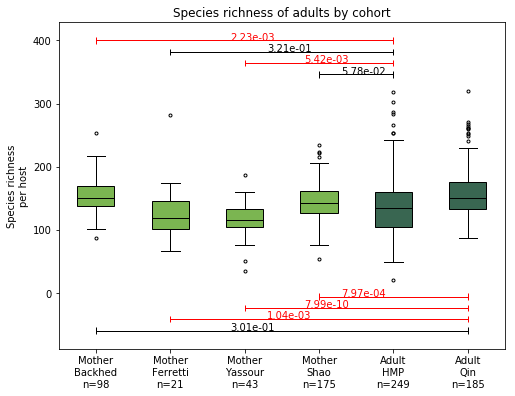

In [16]:
# Mom from each cohort, HMP1-2, Qin, pick one sample per host

richnesses_mother_by_subject = {}

for sample in mother_samples:
    subject = sample_subject_map[sample]
    richness = richness_dict[sample]
    richnesses_mother_by_subject[subject] = (richness, sample)

richnesses_mother_by_cohort = defaultdict(list)

sample_cohort_map = su.parse_sample_cohort_map()
mother_samples = su.get_sample_names('mother')
hmp_samples = su.get_sample_names('hmp')
mother_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

for subject in richnesses_mother_by_subject:
    richness, rep_sample = richnesses_mother_by_subject[subject]
    cohort = sample_cohort_map[rep_sample]
    richnesses_mother_by_cohort[cohort].append(richness)

richnesses = []
labels = []
for cohort in mother_cohorts:
    richnesses.append(richnesses_mother_by_cohort[cohort])
    labels.append('Mother\n%s\nn=%i' % (cohort.capitalize(), len(richnesses_mother_by_cohort[cohort])))

richnesses_hmp_by_subject = {}
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    richness = richness_dict[sample]
    richnesses_hmp_by_subject[subject] = richness

richnesses.append(richnesses_hmp_by_subject.values())
labels.append('Adult\nHMP\nn=%i' % (len(richnesses_hmp_by_subject)))

richnesses_qin_by_subject = {}
for sample in qin_richness_dict:
    subject = qin_sample_subject_map[sample]
    richness = qin_richness_dict[sample]
    richnesses_qin_by_subject[subject] = richness              
              
richnesses.append(richnesses_qin_by_subject.values())
labels.append('Adult\nQin\nn=%i' % (len(richnesses_qin_by_subject)))

fig, ax = plt.subplots(figsize=(8, 6))

medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(richnesses, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes'][:4]:
    patch.set_facecolor('#7bb551')
for patch in boxplots['boxes'][-2:]:
    patch.set_facecolor('#396651')

# Perform pairwise t-test
j = 0
for i in [0, 1, 2, 3]:
    a1 = richnesses[i]
    a2 = richnesses[4] # Compare to HMP first
    t, p = scipy.stats.ttest_ind(a1, a2)
    color = 'red' if p < 0.05 else 'black'
    plot_interval(400 - (60*j), i+1, 5, color=color, tickh=5)
    plt.text(0.8+i+((4-i)/2.0), 400 - (60*j) + 1, '{:.2e}'.format(p), color=color)
    j += 0.3

j = 0
for i in [0, 1, 2, 3]:
    a1 = richnesses[i]
    a2 = richnesses[5] # Compare to Qin
    t, p = scipy.stats.ttest_ind(a1, a2)
    print(p)
    color = 'red' if p < 0.05 else 'black'
    plot_interval(-60+(60*j), i+1, 6, color=color, tickh=5)
    plt.text(0.8+i+((4-i)/2.0), -60 + (60*j)+1, '{:.2e}'.format(p), color=color)
    j += 0.3

ax.set_ylabel("Species richness\nper host")
ax.set_title("Species richness of adults by cohort")
ax.set_xticklabels(labels)

plt.show()
fig.savefig('%s/richness_adults_by_cohort.pdf' % (config.analysis_directory), bbox_inches='tight')

In [17]:
# Save labels for combined plot
richness_adults_by_cohort_labels = labels

In [18]:
# Statistical significance to asterisk representation mapping
def get_sig_str(pval):
    if pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    elif pval > 0.05:
        return 'ns'

In [18]:
'''
ns: P > 0.05

*: P ≤ 0.05

**: P ≤ 0.01

***: P ≤ 0.001

****: P ≤ 0.0001
'''

'\nns: P > 0.05\n\n*: P \xe2\x89\xa4 0.05\n\n**: P \xe2\x89\xa4 0.01\n\n***: P \xe2\x89\xa4 0.001\n\n****: P \xe2\x89\xa4 0.0001\n'

3.7037455007504035e-12
0.3389608252243167
2.671998141958257e-05
1.8450772850577738e-19
0.30095257610397425
0.0010380843863988405
7.993881414495057e-10
0.0007974364818429491


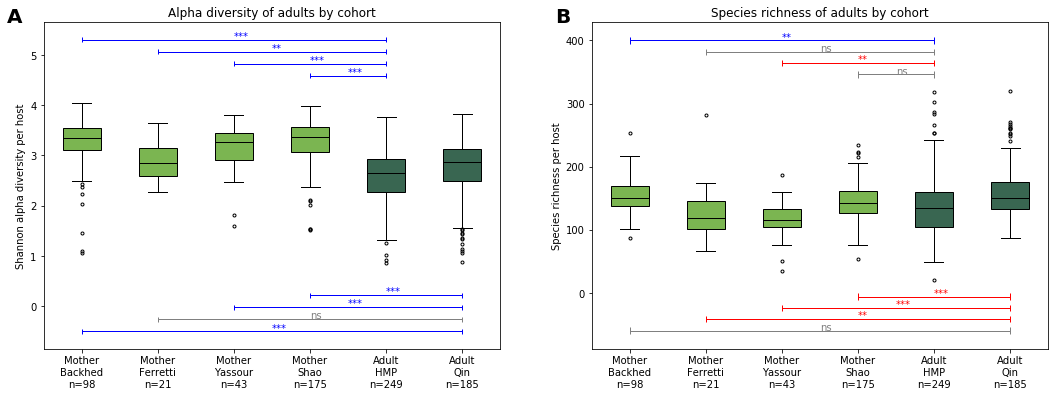

In [19]:
# Combine alpha diversity and richness plots for
# Mom from each cohort, HMP1-2, Qin, pick one sample per host

# Assume individual plots' code has been run

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
medianprops = dict(color='black')
flierprops = dict(marker='.')

# =========================================================
# Alpha diversity
# =========================================================
boxplots = ax[0].boxplot(alpha_divs, patch_artist=True, 
                         medianprops=medianprops,
                         flierprops=flierprops)
for patch in boxplots['boxes'][:4]:
    patch.set_facecolor('#7bb551')
for patch in boxplots['boxes'][-2:]:
    patch.set_facecolor('#396651')

# Perform pairwise t-test
j = 0
for i in [0, 1, 2, 3]:
    a1 = alpha_divs[i]
    a2 = alpha_divs[4] # Compare to HMP first
    t, p = scipy.stats.ttest_ind(a1, a2)
    color = 'red' if t < 0 else 'blue'
    if p > 0.05:
        color = 'gray'
    plot_interval_on_ax(ax[0], 5.3 - (0.8*j), i+1, 5, color=color, tickh=0.05)    
    ax[0].text(1+i+((4-i)/2.0), 5.3 - (0.8*j) +0.01, get_sig_str(p), color=color)
    # ax[0].text(0.8+i+((4-i)/2.0), 5.3 - j+0.02, '{:.2e}'.format(p), color=color)
    j += 0.3

j = 0
for i in [0, 1, 2, 3]:
    a1 = alpha_divs[i]
    a2 = alpha_divs[5] # Compare to Qin
    t, p = scipy.stats.ttest_ind(a1, a2)
    print(p)
    color = 'red' if t < 0 else 'blue'
    if p > 0.05:
        color = 'gray'
    plot_interval_on_ax(ax[0], -0.5 + (0.8*j), i+1, 6, color=color, tickh=0.05)    
    ax[0].text(1+i+((5-i)/2.0), -0.5 + (0.8*j) + 0.01, get_sig_str(p), color=color)
    # ax[0].text(0.8+i+((4-i)/2.0), -0.5+j+0.02, '{:.2e}'.format(p), color=color)
    j += 0.3

ax[0].set_ylabel("Shannon alpha diversity per host")
ax[0].set_title("Alpha diversity of adults by cohort")
ax[0].set_xticklabels(alpha_div_adults_by_cohort_labels)
ax[0].text(-0.08, 1, 'A', size=20, transform=ax[0].transAxes, weight='bold')


# =========================================================
# Richness
# =========================================================
boxplots = ax[1].boxplot(richnesses, patch_artist=True, 
                      medianprops=medianprops,
                      flierprops=flierprops)
for patch in boxplots['boxes'][:4]:
    patch.set_facecolor('#7bb551')
for patch in boxplots['boxes'][-2:]:
    patch.set_facecolor('#396651')

# Perform pairwise t-test
j = 0
for i in [0, 1, 2, 3]:
    a1 = richnesses[i]
    a2 = richnesses[4] # Compare to HMP first
    t, p = scipy.stats.ttest_ind(a1, a2)
    color = 'red' if t < 0 else 'blue'
    if p > 0.05:
        color = 'gray'
    plot_interval_on_ax(ax[1], 400 - (60*j), i+1, 5, color=color, tickh=5)    
    ax[1].text(1+i+((4-i)/2.0), 400 - (60*j) + 1, get_sig_str(p), color=color)
    # ax[1].text(0.8+i+((4-i)/2.0), 400 - (60*j) + 1, '{:.2e}'.format(p), color=color)
    j += 0.3

j = 0
for i in [0, 1, 2, 3]:
    a1 = richnesses[i]
    a2 = richnesses[5] # Compare to Qin
    t, p = scipy.stats.ttest_ind(a1, a2)
    print(p)
    color = 'red' if t < 0 else 'blue' # red means negative t
    if p > 0.05:
        color = 'gray'
    plot_interval_on_ax(ax[1], -60+(60*j), i+1, 6, color=color, tickh=5)
    ax[1].text(1+i+((5-i)/2.0), -60 + (60*j)+1, get_sig_str(p), color=color)
    # ax[1].text(0.8+i+((4-i)/2.0), -60 + (60*j)+1, '{:.2e}'.format(p), color=color)
    j += 0.3

ax[1].set_ylabel("Species richness per host")
ax[1].set_title("Species richness of adults by cohort")
ax[1].set_xticklabels(richness_adults_by_cohort_labels)
ax[1].text(-0.08, 1, 'B', size=20, transform=ax[1].transAxes, weight='bold')

plt.show()
plt.subplots_adjust(wspace=0)
fig.savefig('%s/alpha_div_and_richness_adults_by_cohort.pdf' % (config.analysis_directory), bbox_inches='tight')

In [25]:
# Why trends in alpha diversity and richness different?
# Ideas: (1) Plot aplpha diversity vs. richness
# (2) Look at individual samples

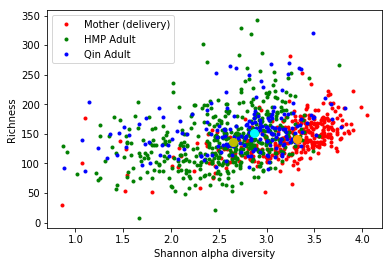

In [52]:
alpha_divs_mother = []
richnesses_mother = []
samples_mother = []

for tp in mother_tps_ordered:
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    
    samples_tp = list(mi_tp_sample_dict['mother'][tp])
    alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['mother'][tp]]
    richnesses_tp = [richness_dict[sample] for sample in mi_tp_sample_dict['mother'][tp]]
    
    samples_mother += samples_tp    
    alpha_divs_mother += alpha_divs_tp
    richnesses_mother += richnesses_tp

samples_hmp = hmp_samples # kek
alpha_divs_hmp = [alpha_div_dict[sample] for sample in samples_hmp]
richnesses_hmp = [richness_dict[sample] for sample in samples_hmp]

samples_qin = list(qin_sample_subject_map.keys())
alpha_divs_qin = [qin_alpha_div_dict[sample] for sample in samples_qin]
richnesses_qin = [qin_richness_dict[sample] for sample in samples_qin]

fig, ax = plt.subplots()

ax.plot(alpha_divs_mother, richnesses_mother, 'r.', label="Mother (delivery)")
ax.plot(alpha_divs_hmp, richnesses_hmp, 'g.', label="HMP Adult")
ax.plot(alpha_divs_qin, richnesses_qin, 'b.', label="Qin Adult")
ax.plot(np.median(alpha_divs_mother), np.median(richnesses_mother), '.', color='orange', markersize=16)
ax.plot(np.median(alpha_divs_hmp), np.median(richnesses_hmp), 'y.', markersize=16)
ax.plot(np.median(alpha_divs_qin), np.median(richnesses_qin), '.', color='cyan', markersize=16)
ax.set_ylabel("Richness")
ax.set_xlabel("Shannon alpha diversity")
ax.legend()

# So yes, mother samples do seem to have higher median alpha diversity but comparable median richness

plt.show()

In [25]:
# Pick out example
mother_examples = []
for alpha_div, richness, sample in zip(alpha_divs_mother, richnesses_mother, samples_mother):
    if alpha_div > 3.5 and richness < 120:
        mother_examples.append(sample)

hmp_examples = []
for alpha_div, richness, sample in zip(alpha_divs_hmp, richnesses_hmp, samples_hmp):
    if alpha_div < 2.5 and richness == 117:
        hmp_examples.append(sample)

NameError: name 'richnesses_mother' is not defined

In [57]:
# Overlap in species when richness is the same?
for adult_sample in hmp_examples:
    mother_species = set(relab_dict['ERR3405313'].keys())
    adult_species = set(relab_dict[adult_sample].keys())
    intersection = mother_species.intersection(adult_species)
    print("%i species are shared out of %i" % (len(intersection), len(mother_species)))

47 species are shared out of 117
52 species are shared out of 117
58 species are shared out of 117
55 species are shared out of 117
48 species are shared out of 117


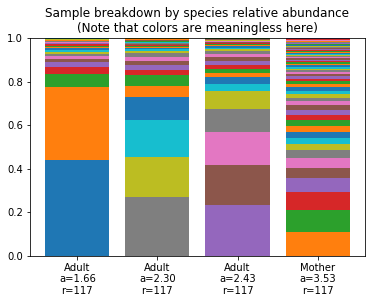

In [48]:
fig, ax = plt.subplots()

labels = []

i = 0
for sample in ['700015857', '700164870', '700105312', 'ERR3405313']:
    relab_vals = []
    for species, relab in sorted(relab_dict[sample].items(), key=lambda x: x[1], reverse=True):
        relab_vals.append(relab)

    acc = 0
    for relab_val in relab_vals:
        ax.bar(i, relab_val, bottom=acc)
        acc += relab_val
    
    htype = 'Mother' if sample in mother_samples else 'Adult'
    label = "%s\na=%.02f\nr=%i" % (htype, alpha_div_dict[sample], richness_dict[sample])
    labels.append(label)
    i += 1

ax.set_title("Sample breakdown by species relative abundance\n(Note that colors are meaningless here)")
ax.set_xticks(np.arange(i))
ax.set_xticklabels(labels)

plt.show()

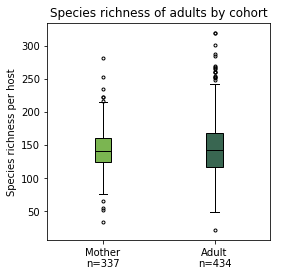

In [94]:
# Mom from each cohort, HMP1-2, Qin, pick one sample per host

richnesses_mother_by_subject = {}

for sample in mother_samples:
    subject = sample_subject_map[sample]
    richness = richness_dict[sample]
    richnesses_mother_by_subject[subject] = richness

richnesses = []
labels = []

richnesses.append(richnesses_mother_by_subject.values())
labels.append('Mother\nn=%i' % (len(richnesses_mother_by_subject)))

richnesses_hmp_by_subject = {}
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    richness = richness_dict[sample]
    richnesses_hmp_by_subject[subject] = richness

richnesses_qin_by_subject = {}
for sample in qin_richness_dict:
    subject = qin_sample_subject_map[sample]
    richness = qin_richness_dict[sample]
    richnesses_qin_by_subject[subject] = richness              

richnesses_adults = richnesses_hmp_by_subject.values() + richnesses_qin_by_subject.values()
richnesses.append(richnesses_adults)
labels.append('Adult\nn=%i' % (len(richnesses_adults)))

fig, ax = plt.subplots(figsize=(4, 4))

medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(richnesses, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
boxplots['boxes'][0].set_facecolor('#7bb551')
boxplots['boxes'][1].set_facecolor('#396651')

ax.set_ylabel("Species richness per host")
ax.set_title("Species richness of adults by cohort")
ax.set_xticklabels(labels)

plt.show()
fig.savefig('%s/richness_mothers_vs_adults.pdf' % (config.analysis_directory), bbox_inches='tight')

In [95]:
scipy.stats.ttest_ind(richnesses[0], richnesses[1])

Ttest_indResult(statistic=-1.176882740102553, pvalue=0.23960645562046665)

<Figure size 432x288 with 0 Axes>

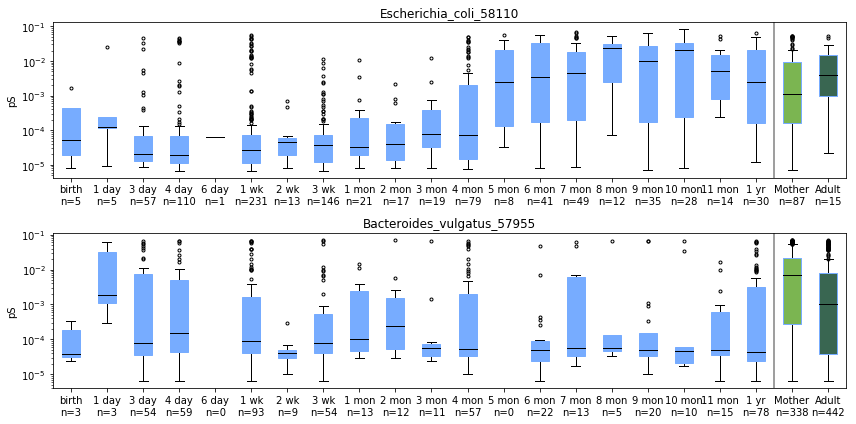

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))

species_list = good_species_list[0:2]

all_tps = tps_ordered_dict['infant'] + ['Mother', 'Adult']

for i in range(len(species_list)):
    desired_species = species_list[i]
    data = []
    labels = []
    
    polymorphism_by_tp_dict = defaultdict(list)
    
    for sample in mother_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['Mother'].append(polymorphism)
    
    for sample in hmp_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['Adult'].append(polymorphism)
    
    for tp in mi_tp_sample_dict['infant']:
        for sample in mi_tp_sample_dict['infant'][tp]:
            for species in sample_species_polymorphism_dict[sample]:
                polymorphism = sample_species_polymorphism_dict[sample][species]
                if species == desired_species:
                    polymorphism_by_tp_dict[tp].append(polymorphism)
    
    for tp in all_tps:
        polymorphisms = polymorphism_by_tp_dict[tp]
        data.append(polymorphisms)
        labels.append("%s\nn=%i" % (tp, len(polymorphisms)))
    
    ax[i].set_yscale('log')
    boxprops = dict(color='#77acff')
    medianprops = dict(color='black')
    flierprops = dict(marker='.')
    boxplots = ax[i].boxplot(data, patch_artist=True, 
                             boxprops=boxprops,
                             medianprops=medianprops,
                             flierprops=flierprops)
    for patch in boxplots['boxes'][:-2]:
        patch.set_facecolor('#77acff')
    boxplots['boxes'][-1].set_facecolor('#396651')
    boxplots['boxes'][-2].set_facecolor('#7bb551')
    ax[i].set_title('%s' % desired_species)
    ax[i].axvline(x=20.5, color='gray')
    ax[i].set_ylabel("pS")
    ax[i].set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [22]:
good_species_list[0:30]

['Escherichia_coli_58110',
 'Bacteroides_vulgatus_57955',
 'Enterococcus_faecalis_56297',
 'Bifidobacterium_longum_57796',
 'Bifidobacterium_breve_57133',
 'Klebsiella_pneumoniae_54788',
 'Staphylococcus_epidermidis_57523',
 'Bacteroides_uniformis_57318',
 'Bifidobacterium_bifidum_55065',
 'Bacteroides_ovatus_58035',
 'Veillonella_parvula_57794',
 'Alistipes_putredinis_61533',
 'Bacteroides_fragilis_54507',
 'Prevotella_copri_61740',
 'Clostridium_perfringens_56840',
 'Enterobacter_cloacae_58148',
 'Bacteroides_stercoris_56735',
 'Veillonella_parvula_58184',
 'Klebsiella_oxytoca_56762',
 'Parabacteroides_distasonis_56985',
 'Veillonella_atypica_58169',
 'Citrobacter_freundii_56148',
 'Klebsiella_oxytoca_57801',
 'Streptococcus_salivarius_58037',
 'Clostridium_paraputrificum_59909',
 'Enterobacter_aerogenes_55704',
 'Bacteroides_caccae_53434',
 'Bacteroides_xylanisolvens_57185',
 'Clostridium_butyricum_56361',
 'Eubacterium_rectale_56927']

In [15]:
# Find most prevalent species among infants

species_nonzero_count = defaultdict(int)

for sample in infant_samples:
    for species in relab_dict[sample]:
        if relab_dict[sample][species] > 0:
            species_nonzero_count[species] += 1

species_infant_prev_ordered = []
for species, count in sorted(species_nonzero_count.items(), key=lambda x: x[1], reverse=True):
    species_infant_prev_ordered.append(species)

In [16]:
species_infant_prev_ordered

['Bifidobacterium_longum_57796',
 'Streptococcus_salivarius_58037',
 'Streptococcus_salivarius_58022',
 'Escherichia_coli_58110',
 'Enterococcus_faecalis_56297',
 'Streptococcus_vestibularis_56030',
 'Staphylococcus_epidermidis_57523',
 'Bifidobacterium_breve_57133',
 'Escherichia_fergusonii_56914',
 'Streptococcus_thermophilus_54772',
 'Streptococcus_parasanguinis_58487',
 'Staphylococcus_sp_59500',
 'Streptococcus_parasanguinis_62442',
 'Streptococcus_sp_60086',
 'Streptococcus_parasanguinis_62481',
 'Escherichia_coli_57907',
 'Streptococcus_sp_62701',
 'Streptococcus_parasanguinis_58126',
 'Veillonella_dispar_61763',
 'Escherichia_albertii_56276',
 'Streptococcus_parasanguinis_58381',
 'Veillonella_sp_62404',
 'Rothia_mucilaginosa_62109',
 'Veillonella_parvula_57794',
 'Salmonella_bongori_55351',
 'Rothia_mucilaginosa_58144',
 'Veillonella_parvula_58184',
 'Bacteroides_vulgatus_57955',
 'Haemophilus_parainfluenzae_62356',
 'Haemophilus_parainfluenzae_62468',
 'Veillonella_atypica_58

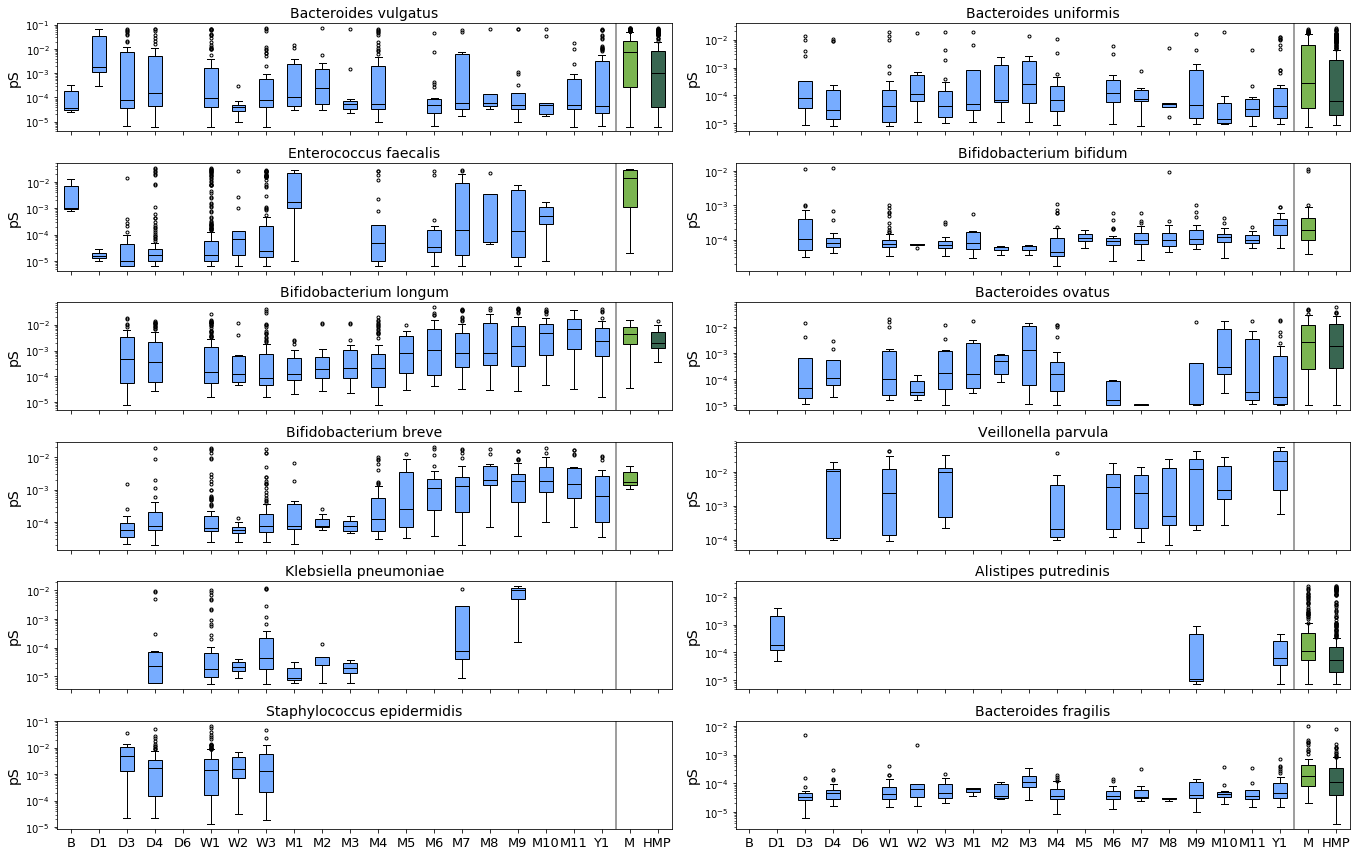

In [29]:
fig, ax = plt.subplots(6, 2, figsize=(19,12), sharex=True)

species_list = good_species_list[1:13] # species_infant_prev_ordered[:3] + species_infant_prev_ordered[4:13]

infant_tps = tps_ordered_dict['infant']
# infant_tps.remove('6 day')
all_tps = infant_tps + ['Mother', 'HMP']
all_tps_abbreviated = ['B'] + [(label.split(' ')[1][0].upper() + label.split(' ')[0]) for label in tps_ordered_dict['infant'][1:]] + ['M', 'HMP']

i = 0
j = 0
for desired_species in species_list:
    
    data = []
    labels = []
    
    polymorphism_by_tp_dict = defaultdict(list)
    
    for sample in mother_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['Mother'].append(polymorphism)
    
    for sample in hmp_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['HMP'].append(polymorphism)
    
    for tp in mi_tp_sample_dict['infant']:
        for sample in mi_tp_sample_dict['infant'][tp]:
            for species in sample_species_polymorphism_dict[sample]:
                polymorphism = sample_species_polymorphism_dict[sample][species]
                if species == desired_species:
                    polymorphism_by_tp_dict[tp].append(polymorphism)
    
    for tp in all_tps:
        polymorphisms = polymorphism_by_tp_dict[tp]
        if len(polymorphisms) < 3: # Don't show if < 3 samples
            data.append([])
        else:
            data.append(polymorphisms)
        labels.append("%s\nn=%i" % (tp, len(polymorphisms)))
    
    ax[i][j].set_yscale('log')
    boxprops = dict(color='#77acff')
    medianprops = dict(color='black')
    flierprops = dict(marker='.')
    boxplots = ax[i][j].boxplot(data, patch_artist=True, 
                             medianprops=medianprops,
                             flierprops=flierprops)
    for patch in boxplots['boxes'][:-2]:
        patch.set_facecolor('#77acff')
    boxplots['boxes'][-1].set_facecolor('#396651')
    boxplots['boxes'][-2].set_facecolor('#7bb551')
    ax[i][j].set_title('%s' % plot_utils.get_pretty_species_name(desired_species), fontsize=14)
    ax[i][j].axvline(x=20.5, color='gray')
    ax[i][j].set_ylabel("pS", fontsize=14)
    ax[5][j].set_xticklabels(all_tps_abbreviated, fontsize=13)
    
    if i < 6:
        i += 1
    
    if i == 6:
        i = 0
        j = 1

plt.tight_layout()
plt.show()

fig.savefig('%s/polymorphism_top_12_prevalence_species.pdf' % (config.analysis_directory), bbox_inches='tight')
fig.savefig('%s/polymorphism_top_12_prevalence_species.png' % (config.analysis_directory), bbox_inches='tight', dpi=500)

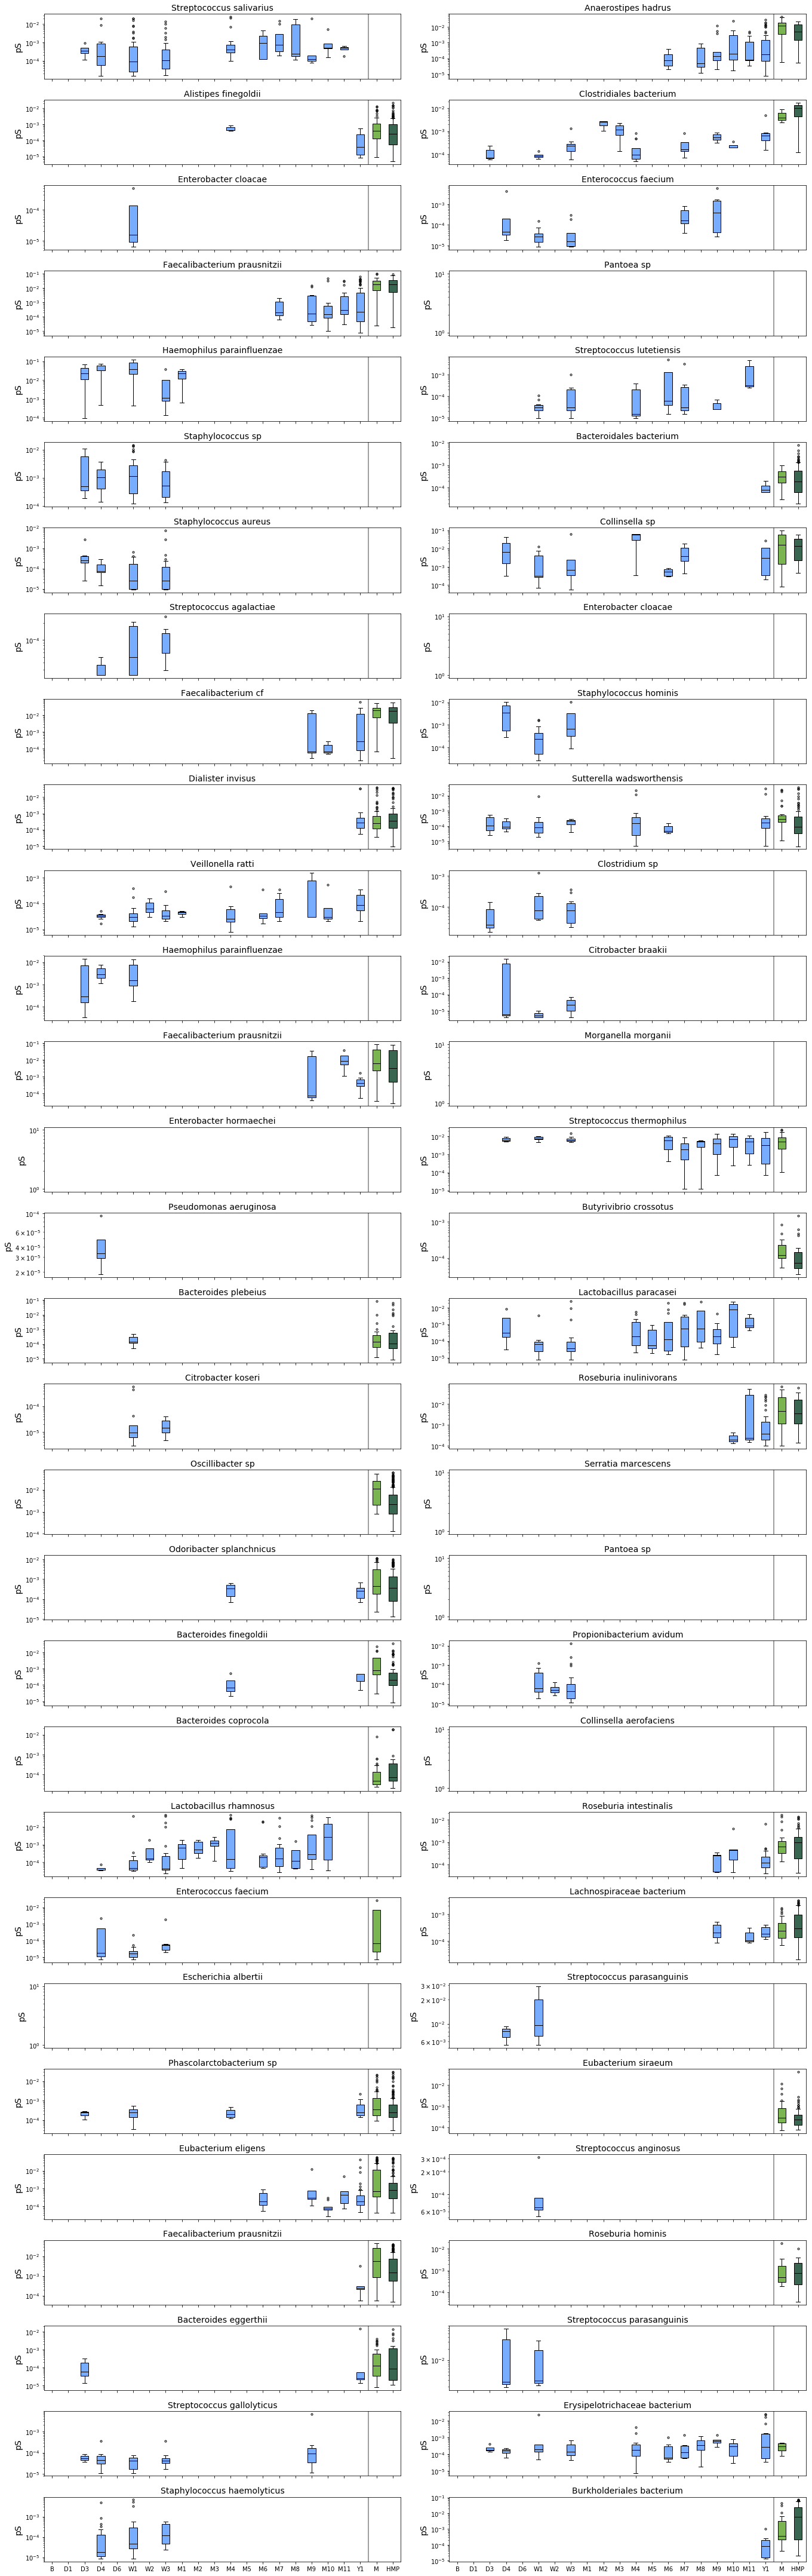

In [12]:
# Final: literally everything

fig, ax = plt.subplots(30, 2, figsize=(19,60), sharex=True)

species_list = good_species_list[60:120]

all_tps = tps_ordered_dict['infant'] + ['Mother', 'HMP']
all_tps_abbreviated = ['B'] + [(label.split(' ')[1][0].upper() + label.split(' ')[0]) for label in tps_ordered_dict['infant'][1:]] + ['M', 'HMP']

i = 0
j = 0
for desired_species in species_list:
    
    data = []
    labels = []
    
    polymorphism_by_tp_dict = defaultdict(list)
    
    for sample in mother_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['Mother'].append(polymorphism)
    
    for sample in hmp_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['HMP'].append(polymorphism)
    
    for tp in mi_tp_sample_dict['infant']:
        for sample in mi_tp_sample_dict['infant'][tp]:
            for species in sample_species_polymorphism_dict[sample]:
                polymorphism = sample_species_polymorphism_dict[sample][species]
                if species == desired_species:
                    polymorphism_by_tp_dict[tp].append(polymorphism)
    
    for tp in all_tps:
        polymorphisms = polymorphism_by_tp_dict[tp]
        if len(polymorphisms) < 3: # Don't show if < 3 samples
            data.append([])
        else:
            data.append(polymorphisms)
        labels.append("%s\nn=%i" % (tp, len(polymorphisms)))
    
    ax[i][j].set_yscale('log')
    boxprops = dict(color='#77acff')
    medianprops = dict(color='black')
    flierprops = dict(marker='.')
    boxplots = ax[i][j].boxplot(data, patch_artist=True, 
                             medianprops=medianprops,
                             flierprops=flierprops)
    for patch in boxplots['boxes'][:-2]:
        patch.set_facecolor('#77acff')
    boxplots['boxes'][-1].set_facecolor('#396651')
    boxplots['boxes'][-2].set_facecolor('#7bb551')
    ax[i][j].set_title('%s' % plot_utils.get_pretty_species_name(desired_species), fontsize=14)
    ax[i][j].axvline(x=20.5, color='gray')
    ax[i][j].set_ylabel("pS", fontsize=14)
    ax[4][j].set_xticklabels(all_tps_abbreviated, fontsize=14)
    
    if i < 30:
        i += 1
    
    if i == 30:
        i = 0
        j = 1

plt.tight_layout()
plt.show()

# fig.savefig('%s/polymorphism_top_12_prevalence_species.pdf' % (config.analysis_directory), bbox_inches='tight')
# fig.savefig('%s/polymorphism_top_12_prevalence_species.png' % (config.analysis_directory), bbox_inches='tight', dpi=500)

We excluded some species because they didn’t have enough data. What was the criteria for that? 

Also, TODO: make pretty with same colors from Fig 1. Increase the font size for the axes labels. Remove the redundant labels for the time to de-clutter, but, keep sample size. Remove boxes with <3 samples. In legend say that each box plot is composed of >n samples

Make pretty the species name (remove the number)

Change ‘adult’ label to be HMP since technically mothers are adults. 

Are the species ordered in some manner? 


In [59]:
# Investigate specific species
desired_species = 'Bifidobacterium_breve_57133'
# desired_species = 'Enterococcus_faecalis_56297'
# desired_species = 'Bifidobacterium_bifidum_55065'

for desired_species in ['Bifidobacterium_breve_57133', 'Enterococcus_faecalis_56297', 'Bifidobacterium_bifidum_55065']:
    mother_days = []
    for sample in sample_species_polymorphism_dict:
        if sample not in mother_samples:
                continue
        
        if desired_species in sample_species_polymorphism_dict[sample]:
            mother_days.append(mi_sample_day_dict[sample])
        
            subject = sample_subject_map[sample]
            host_mother_samples = subject_sample_map[subject].keys()
            if len(host_mother_samples) > 1:
                print(sample_cohort_map[sample])
                print("Is the species also present postpartum?")
                for sample2 in host_mother_samples:
                    if sample2 not in mi_sample_day_dict: # happens if non-fecal?
                        continue
                    if desired_species in sample_species_polymorphism_dict[sample2]:
                        print("%s present at day %i" % (desired_species, mi_sample_day_dict[sample2]))
                    else:
                        print("%s absent at day %i" % (desired_species, mi_sample_day_dict[sample2]))
        
    print("Days of mother samples (n=%i) having %s in SFS map/polymorphism info:" % (len(mother_days), desired_species))
    print(mother_days)  

Days of mother samples (n=3) having Bifidobacterium_breve_57133 in SFS map/polymorphism info:
[1, 1, 1]
yassour
Is the species also present postpartum?
Enterococcus_faecalis_56297 present at day 0
Enterococcus_faecalis_56297 absent at day 92
Enterococcus_faecalis_56297 absent at day -92
Days of mother samples (n=4) having Enterococcus_faecalis_56297 in SFS map/polymorphism info:
[0, 1, 1, 2]
yassour
Is the species also present postpartum?
Bifidobacterium_bifidum_55065 absent at day -92
Bifidobacterium_bifidum_55065 present at day 0
Bifidobacterium_bifidum_55065 absent at day 92
Days of mother samples (n=54) having Bifidobacterium_bifidum_55065 in SFS map/polymorphism info:
[2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [47]:
# How does number of mothers having polymorphism info for these species
# compare to number of mothers that have that species present at all?
# Subject to some presence threshold

threshold = 0

for desired_species in ['Bifidobacterium_breve_57133', 'Enterococcus_faecalis_56297', 'Bifidobacterium_bifidum_55065']:
    mother_samples_pres = set()
    mother_subjects_pres = set()
    for sample in mother_samples:
        if desired_species not in relab_dict[sample]:
            relab = 0
        else:
            relab = relab_dict[sample][desired_species]
        if relab > threshold:
            mother_samples_pres.add(sample)
            mother_subjects_pres.add(sample_subject_map[sample])
    print("%i mother samples / %i subjects have %s present" % (len(mother_samples_pres), 
                                                               len(mother_subjects_pres), desired_species))

142 mother samples / 142 subjects have Bifidobacterium_breve_57133 present
130 mother samples / 130 subjects have Enterococcus_faecalis_56297 present
174 mother samples / 174 subjects have Bifidobacterium_bifidum_55065 present


Sample sizes range from 5 to 231 with median of 28.00.


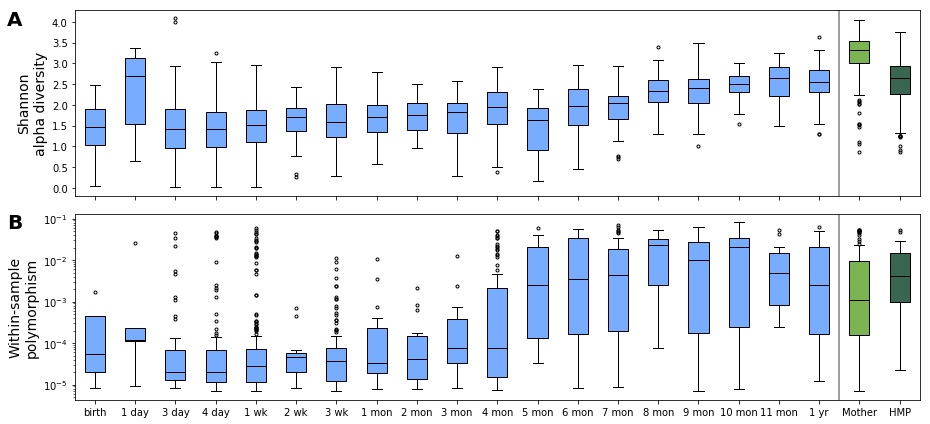

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(13,6), sharex=True)

species_list = good_species_list[0:2]

infant_tps = [tp for tp in tps_ordered_dict['infant']]
infant_tps.remove('6 day')
all_tps = infant_tps + ['Mother', 'Adult']

# Alpha diversity ========================================
alpha_divs = [] # list of sample values for each tp
labels = []

for tp in infant_tps:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    labels.append(tp) # labels.append(tp + "\n" + ("n=%i" % num_samples))
    alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['infant'][tp]]
    alpha_divs.append(alpha_divs_tp)

alpha_divs_mother_combined = []
for i in range(len(mother_tps_ordered)):
    tp = mother_tps_ordered[i]
    num_samples = len(mi_tp_sample_dict['mother'][tp])
    alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['mother'][tp]]
    alpha_divs_mother_combined += alpha_divs_tp

alpha_divs.append(alpha_divs_mother_combined)
labels.append('Mother') # labels.append('Mother'+ "\n" + ("n=%i" % len(alpha_divs_mother_combined)))

alpha_divs_hmp = [alpha_div_dict[sample] for sample in hmp_samples]
alpha_divs.append(alpha_divs_hmp)
labels.append('Adult') # labels.append('Adult' + "\n" + ("n=%i" % len(alpha_divs_hmp)))

boxprops = dict(color='#77acff')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax[0].boxplot(alpha_divs, patch_artist=True, 
                         medianprops=medianprops,
                         flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

boxplots['boxes'][-1].set_facecolor('#396651')
boxplots['boxes'][-2].set_facecolor('#7bb551')

ax[0].set_ylabel("Shannon\nalpha diversity", fontsize=14)
# ax[0].set_title("Alpha diversity by timepoint (infants exclude Olm)")
ax[0].axvline(19.5, color='gray', linestyle='-')
ax[0].set_xticklabels(labels)
ax[0].text(-0.08, 0.92, 'A', size=20, transform=ax[0].transAxes, weight='bold')
# ========================================================

# Polymorphism for E. coli ===============================
desired_species = 'Escherichia_coli_58110'
data = []
labels = []
sample_sizes = []

polymorphism_by_tp_dict = defaultdict(list)
for sample in mother_samples:
    if desired_species in sample_species_polymorphism_dict[sample]:
        polymorphism_by_tp_dict['Mother'].append(sample_species_polymorphism_dict[sample][desired_species])

for sample in hmp_samples:
    if desired_species in sample_species_polymorphism_dict[sample]:
        polymorphism_by_tp_dict['Adult'].append(sample_species_polymorphism_dict[sample][desired_species])

for tp in mi_tp_sample_dict['infant']:
    for sample in mi_tp_sample_dict['infant'][tp]:
        if desired_species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][desired_species]
            polymorphism_by_tp_dict[tp].append(polymorphism)

for tp in all_tps:
    polymorphisms = polymorphism_by_tp_dict[tp]
    data.append(polymorphisms)
    tp = 'HMP' if tp == 'Adult' else tp
    labels.append(tp) # labels.append("%s\nn=%i" % (tp, len(polymorphisms)))
    sample_sizes.append(len(polymorphisms))

# Report sample size statistics
print("Sample sizes range from %i to %i with median of %.02f." % (min(sample_sizes), max(sample_sizes), np.median(sample_sizes)))

ax[1].set_yscale('log')
boxprops = dict(color='#77acff')
medianprops = dict(color='black')
flierprops = dict(marker='.')
boxplots = ax[1].boxplot(data, patch_artist=True,
                         medianprops=medianprops,
                         flierprops=flierprops)
for patch in boxplots['boxes'][:-2]:
    patch.set_facecolor('#77acff')
boxplots['boxes'][-1].set_facecolor('#396651')
boxplots['boxes'][-2].set_facecolor('#7bb551')
# ax[1].set_title('$\\it{Escherichia}$ $\\it{coli}$', fontsize=14)# '$\it{%s}$' % plot_utils.get_pretty_species_name(desired_species), fontsize=14)
ax[1].axvline(x=19.5, color='gray')
ax[1].set_ylabel("Within-sample\npolymorphism", fontsize=14)
ax[1].set_xticklabels(labels)
ax[1].text(-0.08, 0.92, 'B', size=20, transform=ax[1].transAxes, weight='bold')
# ========================================================

plt.tight_layout()
plt.show()
fig.savefig('%s/alpha_div_and_polymorphism_over_time.png' % (config.analysis_directory), bbox_inches='tight', dpi=600)

In [22]:
'$\it{%s}$' % plot_utils.get_pretty_species_name(desired_species)

'$\\it{Escherichia coli}$'

In [10]:
# Get range of all polymorphism
all_polymorphism = []
for sample in sample_species_polymorphism_dict:
    for species in sample_species_polymorphism_dict[sample]:
        all_polymorphism.append(sample_species_polymorphism_dict[sample][species])

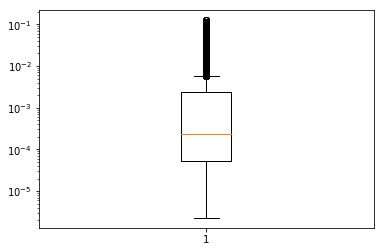

In [15]:
plt.boxplot(all_polymorphism)
plt.yscale('log')
plt.show()

In [21]:
np.quantile(all_polymorphism, 0.75)

0.0023670551939079243

In [28]:
# Follow relative abundance of species and its polymorphism



# Relative abundance file
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (config.data_directory)
relab_file = open(relab_fpath, 'r')
decompressor = bz2.BZ2Decompressor()
raw = decompressor.decompress(relab_file.read())
data = [row.split('\t') for row in raw.split('\n')]
data.pop() # Get rid of extra element due to terminal newline
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
relab_dict = {sample: {} for sample in header}
for i in range(1, len(header)):
    sample = header[i]
    for row in data[1:]:
        species = row[0]
        relab_dict[sample][species] = float(row[i])

In [30]:
for sample in relab_dict:
    if sample not in hmp_samples:
        print(relab_dict[sample]['Bifidobacterium_breve_57133'])

3.29321416901e-05
0.698071053085
2.33629639193e-05
0.706531782843
0.0568398193055
0.0
0.00936770989099
0.375983568376
0.00230701569467
2.00943220965e-05
5.15583952432e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.58666757377e-05
0.0
0.0
0.0
5.23310110453e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0281170823244
0.512791568179
1.74926937995e-05
0.0
6.27382488566e-05
4.55506534253e-05
0.0
9.51454952343e-05
0.000107393349705
0.043217499227
0.392654042974
3.49663226142e-05
0.000105386710519
0.833628647378
0.000156028351453
9.98035434044e-05
0.00311462185793
0.0
0.0
5.49723839286e-05
0.000127474830472
0.0
0.00123586844569
2.59218175231e-05
2.63081885189e-05
0.00200581544955
0.000173717647879
0.940079460843
0.00554929053038
0.127653689755
0.0
0.0
0.0
0.0894441748316
0.065436965517
5.30215534956e-05
0.0966799985965
0.00793808540913
0.0936615812379
0.481675912155
0.040783642692
4.30184167892e-05
0.0629904465461
5.50638353079e-05
0.0
0.116167887878
0.000747424030112
0.0
0.0
0.00060664042099
0.00039275918

KeyError: 'Bifidobacterium_breve_57133'